In [1]:
!pip install -q -U transformers==4.53.3 num2words

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 15.7 MB/s eta 0:00:00


In [2]:
!pip install nuscenes-devkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 58.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.1/313.1 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.7 MB/s eta 0:00:00
  Created wheel for matplotlib: filename=matplotlib-3.5.3-cp311-cp311-linux_x86_64.whl size=11116973 sha256=48b0a2868aad1f487f7d092bfd2d6951b9157f2faa25063b620e02800ba21836
  Stored in directory: /root/.cache/pip/wheels/5d/3b/87/b850f835f7a97bd28b0fb81fd73bdb17755122ea5ad71484f9
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=fc78ebb873364d87b1dda06e18b9d527abe0de6b4ef8805e64ff176a73fb9a21
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6

# Load the Model

In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
from PIL import Image
import num2words

model_path = "HuggingFaceTB/SmolVLM2-2.2B-Instruct"

processor = AutoProcessor.from_pretrained(model_path)
model = AutoModelForImageTextToText.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="cuda",
)

for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/868 [00:00<?, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.03G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

In [ ]:
processor.image_processor.max_image_size["longest_edge"]= 384
processor.image_processor.do_image_splitting=False
processor.image_processor.do_resize=True

# dataset

In [1]:
# Colab setup
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'LLM-Project')
os.chdir(GOOGLE_DRIVE_PATH)

In [3]:
import os
from PIL import Image

nuscenes_path = 'DriveLM/data/nuscenes/samples/'

nuscenes = {}

for folder in os.listdir(nuscenes_path):
    folder_path = os.path.join(nuscenes_path, folder)
    if os.path.isdir(folder_path):
        nuscenes[folder] = {}
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            nuscenes[folder][img_name] = Image.open(img_path)


In [4]:
import json
from datasets import Dataset


class DriveLM:
    def __init__(self, json_path="DriveLM/data/QA_dataset_nus/v1_0_train_nus.json"):

        with open(json_path, 'r') as f:
            data = json.load(f)

        examples = []
        for scene_token, scene_data in data.items():
            scene_desc = scene_data.get('scene_description')
            for frame_token, frame_data in scene_data['key_frames'].items():
                image_paths = frame_data.get('image_paths', {})
                for task, qa_list in frame_data['QA'].items():
                    for qa in qa_list:
                        example = {
                            "scene_token": scene_token,
                            "frame_token": frame_token,
                            "scene_description": scene_desc,
                            "task": task,
                            "question": qa.get("Q"),
                            "answer": qa.get("A"),
                            "context": qa.get("C"),
                            "image_paths": image_paths,
                        }
                        examples.append(example)

        self.hf_dataset = Dataset.from_list(examples)

    def filter(self, function):
        self.hf_dataset = self.hf_dataset.filter(function)


    def __getitem__(self, idx):
      keys = ['scene_description', 'question', 'answer']
      sample = {key: self.hf_dataset[idx][key] for key in keys}

      sample['images'] = {}
      for image_type, image_path in self.hf_dataset[idx]['image_paths'].items():
          image_name = image_path.split('/')[-1]
          sample['images'][image_type] = nuscenes[image_type][image_name]
      return sample

    def __len__(self):
        return len(self.hf_dataset)
dataset = DriveLM()

In [19]:
import re


def contains_object(text):
    return re.search(r'<*>',text) != None

dataset.filter(lambda example: not contains_object(example['question']) and not contains_object(example['answer']))

len(dataset)

Filter:   0%|          | 0/377983 [00:00<?, ? examples/s]

132923

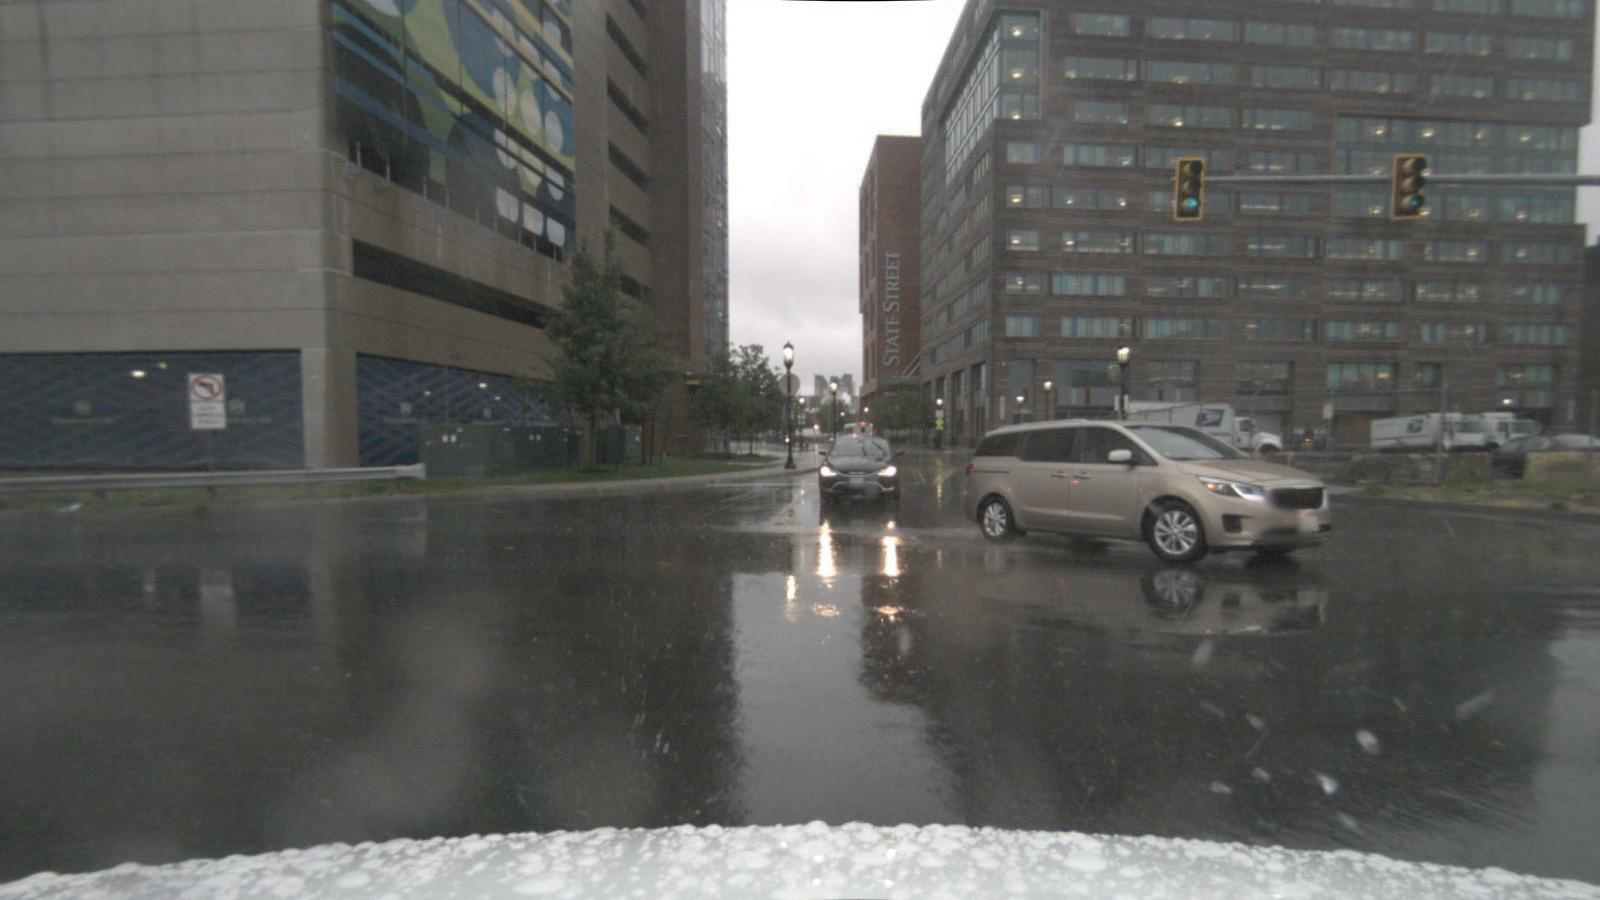

In [27]:
dataset[0]["images"]["CAM_BACK"]

# get the labels

In [1]:
import torch
from datasets import Dataset
from PIL import Image

CAM_KEYS = [
    "CAM_BACK", "CAM_BACK_LEFT", "CAM_BACK_RIGHT",
    "CAM_FRONT", "CAM_FRONT_LEFT", "CAM_FRONT_RIGHT"
]

processed_samples = []

for i in range(len(dataset)):
    for cam in CAM_KEYS:
        image = dataset[i]["images"][cam]
        pixel_values = torch.tensor(processor.image_processor(image).pixel_values)

        with torch.no_grad():
            embedding = model.model.vision_model(pixel_values).last_hidden_state

        processed_samples.append({
            "data": pixel_values,
            "label": embedding,
            "image": image,
            "position": cam
        })

NameError: name 'dataset' is not defined

In [ ]:
hf_dataset = Dataset.from_list(processed_samples)

hf_dataset.push_to_hub("ArianFiroozi/DriveLM-Knowledge-Transfer")